<a href="https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/numba_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from timeit import default_timer as timer
from numba import jit

In [0]:
x = np.arange(100).reshape(10, 10)

@jit(nopython=True)
def go_fast(a): # Function is compiled and runs in machine code
    trace = 0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = timer()
go_fast(x)
end = timer()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = timer()
go_fast(x)
end = timer()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.5545870500000021
Elapsed (after compilation) = 5.390100000113307e-05


In [0]:
from numba import vectorize, int32, float64

a_int = np.arange(10, dtype=np.int32)
a_double = np.arange(10, dtype=np.float64)

@vectorize([int32(int32, int32)])
def f_int(x, y):
    return x + y
  
@vectorize([float64(float64, float64)])
def f_double(x, y):
    return x + y

%timeit f_int(a_int, a_int)
%timeit f_double(a_double, a_double)

413 ns ± 6.25 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
424 ns ± 3.32 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [0]:
from numba import cfunc

def integrand(t):
  return np.exp(-t) / t**2

nb_integrand = cfunc("float64(float64)")(integrand)

In [0]:
import scipy.integrate as si

def do_integrate(func):
  """
  Integrate the given function from 1.0 to +inf.
  """
  return si.quad(func, 1, np.inf)


%timeit do_integrate(integrand)
%timeit do_integrate(nb_integrand.ctypes)

138 µs ± 3.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
28.1 µs ± 702 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Elapsed (with compilation) = 0.2383380729999942
Elapsed (after compilation) = 0.04302575799999886


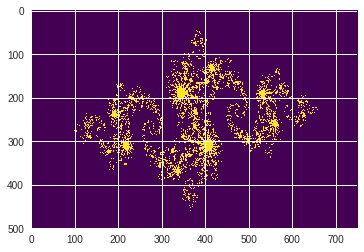

In [0]:
@jit(nopython=True)
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i
    return 255


@jit(nopython=True)  
def julia(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Julia
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(-0.8, 0.156)
    a = complex(x,y)
    for i in range(max_iters):
        a = a*a + c
        if (a.real*a.real + a.imag*a.imag) > 1000:
            return 0
    return 255
  

@jit(nopython=True)
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            #color = mandel(real, imag, iters)
            color = julia(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500, 750), dtype=np.uint8)
start = timer()
create_fractal(-2.0, 2.0, -1.0, 1.0, image, 200)
end = timer()
print("Elapsed (with compilation) = %s" % (end - start))
start = timer()
create_fractal(-2.0, 2.0, -1.0, 1.0, image, 200)
end = timer()
print("Elapsed (after compilation) = %s" % (end - start))
plt.imshow(image)
plt.viridis()
plt.show()

In [0]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so


In [0]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [0]:
from numba import cuda

@cuda.jit
def hello(data):
    data[cuda.blockIdx.x, cuda.threadIdx.x] = cuda.blockIdx.x

numBlocks = 5
threadsPerBlock = 10

data = np.ones((numBlocks, threadsPerBlock), dtype=np.uint8)

hello[numBlocks, threadsPerBlock](data)

print(data)

[[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]]


In [0]:
@cuda.jit
def max_example(result, values):
    """Find the maximum value in values and store in result[0]"""
    tid = cuda.threadIdx.x
    bid = cuda.blockIdx.x
    bdim = cuda.blockDim.x
    i = (bid * bdim) + tid
    cuda.atomic.max(result, 0, values[i])


arr = np.random.rand(16384)
result = np.zeros(1, dtype=np.float64)

max_example[256,64](result, arr)
print(result[0]) # Found using cuda.atomic.max
print(max(arr))  # Print max(arr) for comparision (should be equal!)

In [0]:
@cuda.jit
def compute_pi(rng_states, iterations, out):
    """Find the maximum value in values and store in result[0]"""
    thread_id = cuda.grid(1)

    # Compute pi by drawing random (x, y) points and finding what
    # fraction lie inside a unit circle
    inside = 0
    for i in range(iterations):
        x = xoroshiro128p_uniform_float32(rng_states, thread_id)
        y = xoroshiro128p_uniform_float32(rng_states, thread_id)
        if x**2 + y**2 <= 1.0:
            inside += 1

    out[thread_id] = 4.0 * inside / iterations

threads_per_block = 64
blocks = 24
rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)
out = np.zeros(threads_per_block * blocks, dtype=np.float32)

compute_pi[blocks, threads_per_block](rng_states, 10000, out)
print('pi:', out.mean())

In [0]:
@cuda.jit
def matmul(A, B, C):
    """Perform square matrix multiplication of C = A * B
    """
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

In [0]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

In [0]:
import numpy
from numba import cuda

@cuda.reduce
def sum_reduce(a, b):
    return a + b

A = (numpy.arange(1234, dtype=numpy.float64)) + 1
expect = A.sum()      # numpy sum reduction
got = sum_reduce(A)   # cuda sum reduction
assert expect == got

In [0]:
from numba import vectorize, cuda

# define a device function
@cuda.jit('float32(float32, float32, float32)', device=True, inline=True)
def cu_device_fn(x, y, z):
    return x ** y / z

# define a ufunc that calls our device function
@vectorize(['float32(float32, float32, float32)'], target='cuda')
def cu_ufunc(x, y, z):
    return cu_device_fn(x, y, z)